In [1]:
# !pip install -e ../Maccabee > /dev/null

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from maccabee.data_analysis.data_metrics import AXES_AND_METRIC_NAMES
from maccabee.constants import Constants
import maccabee.data_sources as data_sources
from maccabee.parameters import build_default_parameters

from maccabee.data_generation import DataGeneratingProcess, SampledDataGeneratingProcess, data_generating_method

# benchmarks
from maccabee.benchmarking import benchmark_model_using_concrete_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid

# genmatch
from maccabee.examples.genmatch import GenmatchDataGeneratingProcess, build_genmatch_datasource, GENMATCH_SPECS
from maccabee.examples.genmatch import LogisticPropensityMatchingCausalModel

In [4]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
BASE_GENMATCH_DGP_PARAMS = {
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "TREATMENT_EFFECT_HETEROGENEITY": 0,
  "ACTUAL_CONFOUNDER_ALIGNMENT": 0,
  "MIN_PROPENSITY_SCORE": 0.000000000000001,
  "MAX_PROPENSITY_SCORE": 0.999999999999999,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

A_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
A_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}
  
C_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
C_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.3,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}

G_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
G_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.75,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.1,
    "INTERACTION_THREE_WAY": 0,
}

X_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
X_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.99,
    "POLY_CUBIC": 0.99,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.99,
    "INTERACTION_THREE_WAY": 0,
}

In [6]:
# Define axes and metrics to analyze
DATA_METRICS_SPEC = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
        "Lin r2(X_true, Y)"
    ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)",
        "Lin r2(X_true, Treat Logit)",
        "Log r2(X_obs, T)"
    ],
    Constants.AxisNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
    Constants.AxisNames.BALANCE: [
        "Wass dist X_true: T=1<->T=0",
    ],
    Constants.AxisNames.ALIGNMENT: [
        "Lin r2(Y, Treat Logit)",
        "Lin r2(Y0, Treat Logit)"
    ],
    Constants.AxisNames.TE_HETEROGENEITY: [
        "std(TE)/std(Y)"
    ]
}

In [7]:
N_CORES = 16
N_THREADS=3

## Run MC Benchmarks

In [54]:
%%time

CONCRETE_IN_ANALYSIS_MODE = True

# Concrete Genmatch Benchmark
dgp = GenmatchDataGeneratingProcess(
    *GENMATCH_SPECS["G"],
    n_observations=1000,
    data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE)

concrete_perf_agg, concrete_perf_raw, concrete_data_agg, concrete_data_raw = \
    benchmark_model_using_concrete_dgp(
        dgp=dgp,
        model_class=LogisticPropensityMatchingCausalModel,
        estimand=Constants.Model.ATT_ESTIMAND,
        num_sampling_runs_per_dgp=300,
        num_samples_from_dgp=32,
        data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE,
        data_metrics_spec=DATA_METRICS_SPEC,
        n_jobs=N_CORES,
        n_threads=1)

CPU times: user 25.2 s, sys: 4.32 s, total: 29.5 s
Wall time: 2min 56s


In [9]:
TRUE_TREAT_LOGIT = dgp.treatment_logit_expression

In [55]:
%%time

SAMPLED_IN_ANALYSIS_MODE = True

from maccabee.data_generation.utils import evaluate_expression
# Sampled Genmatch Benchmark
class ModifiedNoiseSampledDataGeneratingProcess(SampledDataGeneratingProcess):
    @data_generating_method(Constants.DGPVariables.OUTCOME_NOISE_NAME, [])
    def _generate_outcome_noise_samples(self, input_vars):
        return 0
    
    @data_generating_method(Constants.DGPVariables.TREATMENT_EFFECT_NAME, [])
    def _generate_treatment_effects(self, input_vars):
        return -0.4
    
#     @data_generating_method(Constants.DGPVariables.PROPENSITY_SCORE_NAME,
#                             [Constants.DGPVariables.COVARIATES_NAME])
#     def _generate_true_propensity_scores(self, input_vars):
#         observed_covariate_data = input_vars[Constants.DGPVariables.COVARIATES_NAME]

#         logits = evaluate_expression(
#             TRUE_TREAT_LOGIT,
#             observed_covariate_data)

#         return 1/(1 + np.exp(-1*logits))
    
dgp_params = build_default_parameters()
dgp_params.set_parameters(G_param_overrides)

sampled_perf_agg, sampled_perf_raw, sampled_perf_run_raw, sampled_data_agg, sampled_data_raw = \
    benchmark_model_using_sampled_dgp(
        dgp_params, build_genmatch_datasource(),
        dgp_kwargs={"data_analysis_mode": SAMPLED_IN_ANALYSIS_MODE},
        dgp_class=ModifiedNoiseSampledDataGeneratingProcess,
        model_class=LogisticPropensityMatchingCausalModel,
        estimand=Constants.Model.ATT_ESTIMAND,
        num_dgp_samples=30,#15,
        num_sampling_runs_per_dgp=10,
        num_samples_from_dgp=32,
        data_analysis_mode=SAMPLED_IN_ANALYSIS_MODE,
        data_metrics_spec=DATA_METRICS_SPEC,
        n_jobs=N_CORES,
        n_threads=1)

CPU times: user 34.5 s, sys: 12.3 s, total: 46.8 s
Wall time: 7min 59s


## Data Metric Comparison

In [56]:
if SAMPLED_IN_ANALYSIS_MODE and CONCRETE_IN_ANALYSIS_MODE:
    for axes, metrics in DATA_METRICS_SPEC.items():
        print(axes)
        for metric in metrics:
            print("\t", metric)

            key = f"{axes} {metric}"
            print("\t\tConcrete:", np.round(concrete_data_agg[key], 3))
            print("\t\tSampled:", np.round(sampled_data_agg[key], 3))
    
    for name, vals in sampled_data_raw.items():
        if name.startswith("TREATMENT_NONLINEARITY"):
            print(name, vals)

OUTCOME_NONLINEARITY
	 Lin r2(X_obs, Y)
		Concrete: 0.971
		Sampled: 0.979
	 Lin r2(X_true, Y)
		Concrete: 0.973
		Sampled: 0.985
TREATMENT_NONLINEARITY
	 Lin r2(X_obs, Treat Logit)
		Concrete: 0.787
		Sampled: 0.679
	 Lin r2(X_true, Treat Logit)
		Concrete: 1.0
		Sampled: 1.0
	 Log r2(X_obs, T)
		Concrete: 0.726
		Sampled: 0.819
PERCENT_TREATED
	 Percent(T==1)
		Concrete: 44.972
		Sampled: 50.599
BALANCE
	 Wass dist X_true: T=1<->T=0
		Concrete: 0.053
		Sampled: 0.082
ALIGNMENT
	 Lin r2(Y, Treat Logit)
		Concrete: 0.031
		Sampled: 0.095
	 Lin r2(Y0, Treat Logit)
		Concrete: 0.006
		Sampled: 0.073
TE_HETEROGENEITY
	 std(TE)/std(Y)
		Concrete: 0.0
		Sampled: 0.0
TREATMENT_NONLINEARITY Log r2(X_obs, T) [0.771, 0.918, 0.881, 0.807, 0.726, 0.829, 0.89, 0.715, 0.773, 0.882, 0.748, 0.836, 0.809, 0.908, 0.776, 0.783, 0.861, 0.729, 0.722, 0.869, 0.864, 0.802, 0.937, 0.698, 0.839, 0.711, 0.956, 0.824, 0.924, 0.776]
TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit) [0.628, 0.952, 0.814, 0.624, 0

## Performance Comparison

Notes

At config A, 20-50 matches across runs. Wide distro. Should investigate the stability of the concrete distro when n=1000.

At config G, 20-50 has much lower bias in the sampled benchmark. The concrete function appears to be a worst case scenario given that very similar functions experience much lower typical bias. The distribution is right tailed and so it is possible that the concrete func chosen is just an (un)lucky sample from right tail.

I will test this by permuting the variable order in the exact same functional form.

### Concrete Performance

In [57]:
concrete_perf_agg

{'RMSE': 0.105, 'RMSE (std)': 0.012, 'AMBP': 13.681, 'AMBP (std)': 3.409}

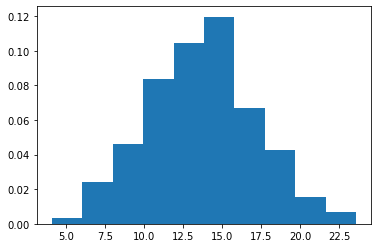

In [58]:
plt.hist(concrete_perf_raw["AMBP"], density=True)
plt.show()

### Sampled Performance

In [59]:
sampled_perf_agg

{'RMSE': 0.331, 'RMSE (std)': 0.217, 'AMBP': 55.209, 'AMBP (std)': 40.16}

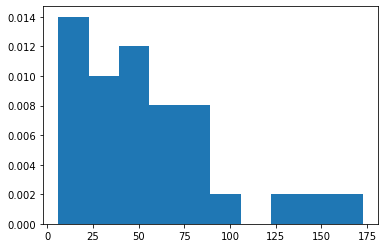

In [60]:
plt.hist(sampled_perf_raw["AMBP"], density=True)
plt.show()

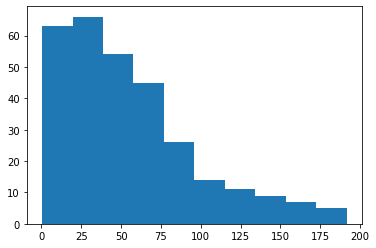

In [61]:
flat_list = [item for sublist in sampled_perf_run_raw["AMBP"] for item in sublist]
plt.hist(flat_list)
plt.show()

In [62]:
sampled_perf_run_raw

defaultdict(list,
            {'RMSE': [[0.22436679853894884,
               0.2138689687635083,
               0.2187372828436421,
               0.19339841079439918,
               0.193251935523918,
               0.252806162940793,
               0.2037197156233474,
               0.21458458960744936,
               0.16307257844036932,
               0.2045789838104328],
              [0.5807384989773805,
               0.6236265158276593,
               0.7544087808316754,
               0.6704149537384665,
               0.5662105683634311,
               0.6712837419926889,
               0.6593409747707891,
               0.6692484156279745,
               0.7096962159611149,
               0.7078620467568738],
              [0.28416322189965193,
               0.2614891034643878,
               0.23613101815688137,
               0.2511173466139692,
               0.2910335375107116,
               0.3056266302351263,
               0.2777583553883309,
               0.323586

### Exploratory Analysis

In [ ]:
# data = np.array(sampled_perf_raw["absolute mean bias %"])
# clean_data = data[data < 20]
# plt.hist(clean_data)
# plt.show()
# np.mean(clean_data)

In [ ]:
# plt.scatter(
#     np.array(sampled_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"])[data < 8],
#     np.array(sampled_perf_raw["absolute mean bias %"])[data < 8])

In [ ]:
# plt.scatter(
#     np.array(sampled_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"])[data < 8],
#     np.array(sampled_perf_raw["absolute mean bias %"])[data < 8],
#     c="b")

# plt.scatter(
#     np.array(concrete_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"]),
#     np.array(concrete_perf_raw["absolute mean bias %"]),
#     c="r")